Notebook to do curved roadway generation

## Changelog
- Friday, Jan 31
    - Creation
    - Toy track generation using way if 10025 from `DR_CHN_Merging_ZS.osm`
- Monday, Feb 3
    - Begin trajdata creation to read in the vehicle tracks. Creation of struct called `INTERACTIONTrajdata`
- Tuesday, Feb 4
    - `Trajdata` reading nominally works. And rendered a scene of course without roadway. Some caveats
        - `car_df_index` line 21 onwards check is commented out
        - No `roadway` involved in the creation of `RecordState`

In [56]:
# usings
using AutomotiveDrivingModels
using AutoViz

In [ ]:
# function: append to curve
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

In [ ]:
# functions: angle calculation
"""
    function append_headings
- Used create the angles and append them into the coordinates

# Examples
```julia
x_coods = [1089.07510, 1093.82626, 1101.19325, 1112.59899, 1123.96733, 1133.24150, 1146.47964]
y_coods = [936.31213, 936.92692,938.52419, 940.93865, 943.27882, 945.21039, 947.88488]
coods = hcat(x_coods,y_coods)
append_headings(coods)
```
"""
function append_headings(coordinates::Matrix{Float64})
    headings = ones(size(coordinates)[1])
    for i = 1:size(coordinates)[1]-1
        # need to make sure that math is right, and that bounds are kept
        tangent_vector = [coordinates[i+1,1]-coordinates[i,1], coordinates[i+1,2]-coordinates[i,2]]
        # @show tangent_vector
        current_heading = get_new_angle(tangent_vector)
        # @show current_heading
        headings[i] = current_heading
    end
    headings[end] = headings[end-1] # assume this is fine
    coordinates = hcat(coordinates, headings)
    return coordinates
end

"""
    function get_new_angle
- Does the actual angle calculation based on the x y coordinates
"""
function get_new_angle(tangent_vector::Array{Float64})
    # it might be a problem when we switch quadrants
    # use signs of tangent vector to get the quadrant of the heading 
    x = tangent_vector[1]
    y = tangent_vector[2]
    if x == 0. && y == 0.
        heading = 0.0
    elseif x == 0.
        heading = π/2 * sign(y) 
    elseif y == 0.
        heading = convert(Float64, π) # this could be either pi or -pi, but just go with pi
    elseif sign(x) == 1 && sign(y) == 1 # first quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == 1 # second quadrant
        heading = atan(y, x)
    elseif sign(x) == 1 && sign(y) == -1 # fourth quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == -1 # third quadrant
        heading = atan(y, x)
    end
    # bound_heading doesn't end up getting called cause Julia takes care of it apparently
    bound_heading(heading)

    return heading
end

"""
    function bound_heading
- Make the angle range from 0 to pi instead of going beyond
"""
function bound_heading(heading::Float64)
    if heading > π # send this to be just near -pi
        heading = -π + (heading - π)    # if heading is 3.15, then the new angle will be (-pi + (3.15-pi)) = -3.13
    elseif heading < -π # send this to be just near pi 
        heading = π + (heading + π)     # if heading is -3.15, then the new angle will be (pi + (-3.15+pi)) = 3.13
    end
    return heading
end

In [ ]:
# WBs example code
"""
- WBs example code
"""
function get_track()

    x_coods = [0., 5.]
    y_coods = [3., 3.]
    theta = [0., 0.]
    
    turn_length = 10
    new_theta = 0.
    incremental_angle = (pi/4) / turn_length
    radius = 1
    for i = 1:turn_length
        push!(theta, new_theta)
        push!(x_coods, x_coods[end] + radius * cos(new_theta))
        push!(y_coods, y_coods[end] + radius * sin(new_theta))
        new_theta -= (incremental_angle)
    end
#     plot(x_coods, y_coods)
    mid_coods = vcat(x_coods', y_coods', theta') # x coods in first row, y coods in second row, theta in third row
    
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    curve_radius = incremental_angle
    nsamples = 1000
    for i = 3:turn_length+2
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, curve_radius, curve_radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

In [ ]:
# function: get_track
"""
    function get_track()

- Generate a track based on x and y coordinates of the centerline
- Extracts angles as an intermediate step
"""
function get_track()
    # way 10025 for illustrate purposes
    x_coods = [1089.07510, 1093.82626, 1101.19325, 1112.59899, 1123.96733, 1133.24150, 1146.47964]
    y_coods = [936.31213, 936.92692,938.52419, 940.93865, 943.27882, 945.21039, 947.88488]

    coods = hcat(x_coods,y_coods)
    coods_app = append_headings(coods) # Append with the angle
    
    mid_coods = coods_app'
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    nsamples = 20
    for i = 3:7
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, radius, radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

In [ ]:
# script: generate the roadway

#nlanes = 1
#length = 50.

#roadway = gen_straight_roadway(nlanes, length)

width = DEFAULT_LANE_WIDTH
roadway = Roadway()

track = get_track()

lane = Lane(LaneTag(1, 2), track, width=DEFAULT_LANE_WIDTH)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))
cam = FitToContentCamera(0.05)
render(roadway, cam=cam)

In [ ]:
@show roadway.segments[1].lanes

## Interaction track experimentation

In [ ]:
# usings: Specific to trajdata
using DataFrames
using Records

In [81]:
# constants: timestep
const INTERACTION_TIMESTEP = 0.1 # unit is second

0.1

In [37]:
# struct: the interaction trajdata
"""
INTERACTIONTrajdata
The trajectory data stored in the original INTERACTION dataset format.
The dataset is a csv file with columns:
    track_id      - Int64 - Representing the id of the agent
    frame_id      - Int64 - Represents the frames in which the agent appears in the video
    timestamp_ms  - Int64 - represents the time the agent appears in the video. The unit is millisecond
    agent_type    - String - Can be person, car, truck and so on
    x             - Float64 - x position, in meter
    y             - Float64 - y position in meter
    vx            - Float64 - x velocity in m/s
    vy            - Float64 - y velocity in m/s
    psi_rad       - Float64 - yaw angle in radian
    length        - Float64 - Length of the vehicle, in meter
    width         - Float64 - Width of the vehicle, in meter

# Example
```julia
tdraw = INTERACTIONTrajdata("vehicle_tracks_000.csv");
```
"""
mutable struct INTERACTIONTrajdata
    df         :: DataFrame
    car2start  :: Dict{Int, Int}         # maps carindex to starting index in the df
    frame2cars :: Dict{Int, Vector{Int}} # maps frame to list of carids in the scene

    function INTERACTIONTrajdata(input_path::String)

        @assert(isfile(input_path))

        df = readtable(input_path, separator=',', header = true)

        car2start = Dict{Int, Int}()
        frame2cars = Dict{Int, Vector{Int}}()

        for (dfind, carid) in enumerate(df[:track_id])
            if !haskey(car2start, carid)
                car2start[carid] = dfind
            end

            frame = convert(Int, df[dfind, :frame_id])
            if !haskey(frame2cars, frame)
                frame2cars[frame] = [carid]
            else
                frame2cars[frame] = push!(frame2cars[frame], carid)
            end
        end

        new(df, car2start, frame2cars)
    end
end

INTERACTIONTrajdata

In [47]:
# function: overload nframes from Records
"""
    Records.nframes

# Example
```julia
tdraw = INTERACTIONTrajdata("vehicle_tracks_000.csv")
nframes(tdraw)
```
"""
Records.nframes(trajdata::INTERACTIONTrajdata) = maximum(keys(trajdata.frame2cars))

In [87]:
# function: carsinframe for memory allocation
"""
    carsinframe(trajdata::INTERACTIONTrajdata, frame::Int)
- From the dictionary `frame2cars` which has frame number as key and all vector of car ids in that frame
as value, this function extracts the value corresponding to key given by `frame`

# Example
```julia
# Return array with car ids in frame 1
carsinframe(tdraw,1)
```
"""
carsinframe(trajdata::INTERACTIONTrajdata, frame::Int) = get(trajdata.frame2cars, frame, Int[])

carsinframe (generic function with 1 method)

In [39]:
# script: read data from csv file into INTERACTIONTrajdata struct and prepare for next steps i.e.
# what Base.convert(::Type{Trajdata}, tdraw::NGSIMTrajdata, roadway::Roadway) does in NGSIM/trajdata.jl
tdraw = INTERACTIONTrajdata("vehicle_tracks_000.csv");
df = tdraw.df
vehdefs = Dict{Int, VehicleDef}()
states = Array{RecordState{VehicleState, Int}}(undef, nrow(df))
frames = Array{RecordFrame}(undef, nframes(tdraw));

In [80]:
# script: initialize the vehicle definition in terms of type, length and width
for (id, dfind) in tdraw.car2start
    # CAUTION: Hardcoding vehicle type to be just car shown by the first argument being 2
    vehdefs[id] = VehicleDef(2, df[dfind, :length], df[dfind, :width])
    #if df[dfind,:agent_type] == "car"
    #    print("dfind is $(dfind)")
    #    print(df[dfind,:agent_type])
    #end
end

In [109]:
# function: car_df_index - find index of car in trajdata
function car_df_index(trajdata::INTERACTIONTrajdata, carid::Int, frame::Int)
    #=
    given frame and carid, find index of car in trajdata
    Returns 0 if it does not exist
    =#

    df = trajdata.df

    lo = trajdata.car2start[carid] # The index in the dataframe where carid first appears
    framestart = df[lo, :frame_id] # The frame number where carid first appears
    print("car_df_index says framestart = $(framestart)\n")
    retval = 0

    if framestart == frame
        retval = lo
    elseif frame ≥ framestart
        print("car_df_index says frame >= framestart\n")
        print("car_df_index says lo = $(lo)")
        retval = frame - framestart + lo
        #n_frames = df[lo, :n_frames_in_dataset]
        #if retval > lo + n_frames
        #    retval = 0
        #end
    end

    retval
end

car_df_index (generic function with 1 method)

In [110]:
# script: loop over data and create the vehicle state sequence. NOTE: THIS NEEDS THE ROADWAY
state_ind = 0
@show nframes(tdraw)
for frame in 1 : nframes(tdraw)
    @show frame
    frame_lo = state_ind+1

    for id in carsinframe(tdraw, frame)
        @show id
        dfind = car_df_index(tdraw, id, frame)
        @show dfind

        posG = VecSE2(df[dfind, :x], df[dfind, :y], df[dfind, :psi_rad])
        vx = df[dfind,:vx]
        vy = df[dfind,:vy]
        speed = sqrt(vx*vx + vy*vy)

        #states[state_ind += 1] = RecordState(VehicleState(posG, roadway, speed), id)
        states[state_ind += 1] = RecordState(VehicleState(posG, speed), id)
    end

    frame_hi = state_ind
    frames[frame] = RecordFrame(frame_lo, frame_hi)
end
Trajdata(INTERACTION_TIMESTEP, frames, states, vehdefs)

nframes(tdraw) = 3512
frame = 1
id = 1
car_df_index says framestart = 1
dfind = 1
id = 2
car_df_index says framestart = 1
dfind = 97
id = 4
car_df_index says framestart = 1
dfind = 135
id = 5
car_df_index says framestart = 1
dfind = 253
id = 6
car_df_index says framestart = 1
dfind = 338
id = 7
car_df_index says framestart = 1
dfind = 510
id = 8
car_df_index says framestart = 1
dfind = 580
id = 9
car_df_index says framestart = 1
dfind = 732
id = 10
car_df_index says framestart = 1
dfind = 772
id = 11
car_df_index says framestart = 1
dfind = 830
id = 12
car_df_index says framestart = 1
dfind = 946
id = 13
car_df_index says framestart = 1
dfind = 1015
id = 14
car_df_index says framestart = 1
dfind = 1153
id = 15
car_df_index says framestart = 1
dfind = 1207
id = 16
car_df_index says framestart = 1
dfind = 1305
id = 17
car_df_index says framestart = 1
dfind = 1324
id = 18
car_df_index says framestart = 1
dfind = 1394
id = 19
car_df_index says framestart = 1
dfind = 1459
id = 20
car_df_ind

car_df_index says frame >= framestart
car_df_index says lo = 1305dfind = 1308
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1327
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1397
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1462
id = 20
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1646dfind = 1649
id = 21
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1728dfind = 1731
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1793
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1891
id = 24
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_ind

id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1021
id = 14
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1153dfind = 1159
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1213
id = 16
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1305dfind = 1311
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1330
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1400
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1465
id = 20
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1646dfind = 1652
id = 21
car_df_index says framestart = 1
car_df_

car_df_index says frame >= framestart
car_df_index says lo = 510dfind = 519
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 589
id = 9
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 732dfind = 741
id = 10
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 772dfind = 781
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 839
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 955
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1024
id = 14
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1153dfind = 1162
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1

car_df_index says lo = 2560dfind = 2571
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2598
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2715
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2861
frame = 13
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 13
id = 2
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 97dfind = 109
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 147
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 265
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 350
id = 7
car_df_i

car_df_index says lo = 1728dfind = 1742
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1804
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1902
id = 24
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1997dfind = 2011
id = 25
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2030dfind = 2044
id = 26
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2065dfind = 2079
id = 27
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2082dfind = 2096
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2132
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2338
id = 30


car_df_index says lo = 946dfind = 963
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1032
id = 14
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1153dfind = 1170
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1224
id = 16
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1305dfind = 1322
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1341
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1411
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1476
id = 20
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1646dfind = 1663
id = 21
ca

car_df_index says lo = 135dfind = 155
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 273
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 358
id = 7
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 510dfind = 530
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 600
id = 9
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 732dfind = 752
id = 10
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 772dfind = 792
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 850
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 966
id = 13
car_df_index says frame

car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2609
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2726
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2872
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3129
frame = 24
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 24
id = 2
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 97dfind = 120
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 158
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 276
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index s

car_df_index says lo = 1790dfind = 1815
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1913
id = 24
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1997dfind = 2022
id = 25
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2030dfind = 2055
id = 27
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2082dfind = 2107
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2143
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2349
id = 30
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2560dfind = 2585
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2612
id = 33


car_df_index says lo = 772dfind = 800
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 858
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 974
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1043
id = 14
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1153dfind = 1181
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1235
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1352
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1422
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1487
id = 20
car_df

car_df_index says lo = 3329dfind = 3333
frame = 32
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 32
id = 2
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 97dfind = 128
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 166
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 284
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 369
id = 7
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 510dfind = 541
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 611
id = 9
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 732dfind = 763
id = 10
car_df_index says

car_df_index says lo = 1888dfind = 1921
id = 25
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2030dfind = 2063
id = 27
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2082dfind = 2115
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2151
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2357
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2620
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2737
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2883
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3140
id = 3

car_df_index says lo = 732dfind = 768
id = 10
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 772dfind = 808
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 866
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 982
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1051
id = 14
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1153dfind = 1189
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1243
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1360
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1430
id = 19
car_df_i

car_df_index says lo = 3787dfind = 3792
frame = 40
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 40
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 174
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 292
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 377
id = 7
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 510dfind = 549
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 619
id = 9
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 732dfind = 771
id = 10
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 772dfind = 811
id = 11
car_df_index sa

id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3264
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3344
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3610
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3675
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3795
frame = 43
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 43
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 177
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 295
id = 6
car_df_index says framestart = 1
car_

car_df_index says lo = 2118dfind = 2162
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2368
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2631
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2748
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2894
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3151
id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3267
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3347
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3613
id 

car_df_index says lo = 1207dfind = 1254
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1371
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1441
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1506
id = 20
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1646dfind = 1693
id = 21
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1728dfind = 1775
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1837
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1935
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2165
id = 29


car_df_index says lo = 135dfind = 185
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 303
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 388
id = 7
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 510dfind = 560
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 630
id = 10
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 772dfind = 822
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 880
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 996
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1065
id = 14
car_df_index says fr

car_df_index says lo = 2859dfind = 2902
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3159
id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3275
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3355
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3621
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3686
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3806
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4014
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4158


car_df_index says lo = 1888dfind = 1943
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2173
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2379
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2642
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2759
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2905
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3162
id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3278
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3358
id =

id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 638
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 888
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 1004
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1073
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1265
id = 17
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1324dfind = 1382
id = 18
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1394dfind = 1452
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1517
id = 20
car_df_index says framestart = 1
car_df_index 

car_df_index says lo = 3600dfind = 3629
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3694
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3814
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4022
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4166
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4458
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4723
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4843
frame = 62
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind =

car_df_index says lo = 1646dfind = 1709
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1853
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1951
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2181
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2387
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2650
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2767
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2913
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3170
id = 3

car_df_index says lo = 135dfind = 201
id = 5
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 253dfind = 319
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 404
id = 7
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 510dfind = 576
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 646
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 896
id = 12
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 946dfind = 1012
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1081
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1273
id = 17
car_df_index says

car_df_index says lo = 3600dfind = 3637
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3702
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3822
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4030
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4174
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4466
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4731
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4851
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4915


car_df_index says lo = 2324dfind = 2395
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2658
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2775
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2921
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3178
id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3294
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3374
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3640
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3705
id

car_df_index says lo = 253dfind = 327
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 412
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 654
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 904
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1089
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1281
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1533
id = 20
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1646dfind = 1720
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1864
id = 23
car_df_ind

car_df_index says lo = 3787dfind = 3830
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4038
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4182
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4474
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4739
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4859
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4923
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
car_df_index says lo = 5053dfind = 5062
id = 48
car_df_index says framestart = 70
car_df_index says frame >= framestart
car_df_index says lo = 5181dfind = 5188


car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1538
id = 20
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1646dfind = 1725
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1869
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1967
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2197
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2403
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2666
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2783
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_in

car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4744
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4864
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4928
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
car_df_index says lo = 5053dfind = 5067
id = 48
car_df_index says framestart = 70
car_df_index says frame >= framestart
car_df_index says lo = 5181dfind = 5193
id = 49
car_df_index says framestart = 72
car_df_index says frame >= framestart
car_df_index says lo = 5248dfind = 5258
id = 50
car_df_index says framestart = 73
car_df_index says frame >= framestart
car_df_index says lo = 5557dfind = 5566
id = 51
car_df_index says framestart = 78
car_df_index says frame >= framestart
car_df_index says lo = 5848dfind = 5852
frame = 83
id = 1
car_df_index says framestart = 1
car_df_index says frame >= fram

car_df_index says lo = 2118dfind = 2202
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2408
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2671
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2788
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2934
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3191
id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3307
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3387
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3653
id 

car_df_index says frame >= framestart
car_df_index says lo = 5557dfind = 5571
id = 51
car_df_index says framestart = 78
car_df_index says frame >= framestart
car_df_index says lo = 5848dfind = 5857
id = 52
car_df_index says framestart = 84
car_df_index says frame >= framestart
car_df_index says lo = 5927dfind = 5930
id = 53
car_df_index says framestart = 86
car_df_index says frame >= framestart
car_df_index says lo = 6071dfind = 6072
frame = 88
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 88
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 222
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 425
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 667
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_inde

car_df_index says lo = 2859dfind = 2939
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3196
id = 36
car_df_index says framestart = 24
car_df_index says frame >= framestart
car_df_index says lo = 3246dfind = 3312
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3392
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3658
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3723
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3843
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4051
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4195


car_df_index says lo = 5927dfind = 5935
id = 53
car_df_index says framestart = 86
car_df_index says frame >= framestart
car_df_index says lo = 6071dfind = 6077
frame = 93
id = 1
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1dfind = 93
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 227
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 430
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 672
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 922
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1107
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1299
id = 19
car_d

car_df_index says lo = 3246dfind = 3317
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3397
id = 38
car_df_index says framestart = 32
car_df_index says frame >= framestart
car_df_index says lo = 3600dfind = 3663
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3728
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3848
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4056
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4200
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4492
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4757


car_df_index says lo = 338dfind = 435
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 677
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 927
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1112
id = 15
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1207dfind = 1304
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1556
id = 22
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1790dfind = 1887
id = 23
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1888dfind = 1985
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2215
id = 29
car_df_

car_df_index says lo = 5181dfind = 5211
id = 49
car_df_index says framestart = 72
car_df_index says frame >= framestart
car_df_index says lo = 5248dfind = 5276
id = 50
car_df_index says framestart = 73
car_df_index says frame >= framestart
car_df_index says lo = 5557dfind = 5584
id = 51
car_df_index says framestart = 78
car_df_index says frame >= framestart
car_df_index says lo = 5848dfind = 5870
id = 52
car_df_index says framestart = 84
car_df_index says frame >= framestart
car_df_index says lo = 5927dfind = 5943
id = 53
car_df_index says framestart = 86
car_df_index says frame >= framestart
car_df_index says lo = 6071dfind = 6085
frame = 101
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 235
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 438
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 680


car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3737
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3857
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4065
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4209
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4501
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4766
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4886
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4950
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
ca

car_df_index says lo = 2710dfind = 2810
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2956
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3213
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3409
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3740
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3860
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4068
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4212
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4504


car_df_index says lo = 2324dfind = 2433
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2696
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2813
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2959
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3216
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3412
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3743
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3863
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4071
id

car_df_index says lo = 338dfind = 450
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 692
id = 11
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 830dfind = 942
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1127
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1571
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2230
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2436
id = 32
car_df_index says framestart = 2
car_df_index says frame >= framestart
car_df_index says lo = 2588dfind = 2699
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2816
id = 34
car_df_

car_df_index says lo = 5848dfind = 5885
id = 52
car_df_index says framestart = 84
car_df_index says frame >= framestart
car_df_index says lo = 5927dfind = 5958
id = 53
car_df_index says framestart = 86
car_df_index says frame >= framestart
car_df_index says lo = 6071dfind = 6100
id = 54
car_df_index says framestart = 108
car_df_index says frame >= framestart
car_df_index says lo = 6201dfind = 6208
id = 55
car_df_index says framestart = 109
car_df_index says frame >= framestart
car_df_index says lo = 6286dfind = 6292
id = 56
car_df_index says framestart = 111
car_df_index says frame >= framestart
car_df_index says lo = 6420dfind = 6424
frame = 116
id = 4
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 135dfind = 250
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 453
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 6

car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4964
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
car_df_index says lo = 5053dfind = 5103
id = 48
car_df_index says framestart = 70
car_df_index says frame >= framestart
car_df_index says lo = 5181dfind = 5229
id = 49
car_df_index says framestart = 72
car_df_index says frame >= framestart
car_df_index says lo = 5248dfind = 5294
id = 50
car_df_index says framestart = 73
car_df_index says frame >= framestart
car_df_index says lo = 5557dfind = 5602
id = 51
car_df_index says framestart = 78
car_df_index says frame >= framestart
car_df_index says lo = 5848dfind = 5888
id = 52
car_df_index says framestart = 84
car_df_index says frame >= framestart
car_df_index says lo = 5927dfind = 5961
id = 53
car_df_index says framestart = 86
car_df_index says frame >= framestart
car_df_index says lo = 6071dfind = 6103
id = 54
car_df_index says framestart = 108
car_df_index says frame >= framestart
c

car_df_index says lo = 4715dfind = 4783
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4903
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4967
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
car_df_index says lo = 5053dfind = 5106
id = 48
car_df_index says framestart = 70
car_df_index says frame >= framestart
car_df_index says lo = 5181dfind = 5232
id = 49
car_df_index says framestart = 72
car_df_index says frame >= framestart
car_df_index says lo = 5248dfind = 5297
id = 50
car_df_index says framestart = 73
car_df_index says frame >= framestart
car_df_index says lo = 5557dfind = 5605
id = 51
car_df_index says framestart = 78
car_df_index says frame >= framestart
car_df_index says lo = 5848dfind = 5891
id = 52
car_df_index says framestart = 84
car_df_index says frame >= framestart
car_df_index says lo = 5927dfind = 5964


car_df_index says lo = 4449dfind = 4521
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4786
id = 45
car_df_index says framestart = 59
car_df_index says frame >= framestart
car_df_index says lo = 4841dfind = 4906
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4970
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
car_df_index says lo = 5053dfind = 5109
id = 48
car_df_index says framestart = 70
car_df_index says frame >= framestart
car_df_index says lo = 5181dfind = 5235
id = 49
car_df_index says framestart = 72
car_df_index says frame >= framestart
car_df_index says lo = 5248dfind = 5300
id = 50
car_df_index says framestart = 73
car_df_index says frame >= framestart
car_df_index says lo = 5557dfind = 5608
id = 51
car_df_index says framestart = 78
car_df_index says frame >= framestart
car_df_index says lo = 5848dfind = 5894


car_df_index says lo = 3667dfind = 3760
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3880
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4088
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4232
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4524
id = 44
car_df_index says framestart = 53
car_df_index says frame >= framestart
car_df_index says lo = 4715dfind = 4789
id = 46
car_df_index says framestart = 63
car_df_index says frame >= framestart
car_df_index says lo = 4909dfind = 4973
id = 47
car_df_index says framestart = 68
car_df_index says frame >= framestart
car_df_index says lo = 5053dfind = 5112
id = 48
car_df_index says framestart = 70
car_df_index says frame >= framestart
car_df_index says lo = 5181dfind = 5238


car_df_index says lo = 2710dfind = 2833
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2979
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3236
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3432
id = 39
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3667dfind = 3763
id = 40
car_df_index says framestart = 34
car_df_index says frame >= framestart
car_df_index says lo = 3787dfind = 3883
id = 41
car_df_index says framestart = 43
car_df_index says frame >= framestart
car_df_index says lo = 4004dfind = 4091
id = 42
car_df_index says framestart = 46
car_df_index says frame >= framestart
car_df_index says lo = 4151dfind = 4235
id = 43
car_df_index says framestart = 52
car_df_index says frame >= framestart
car_df_index says lo = 4449dfind = 4527


car_df_index says lo = 580dfind = 712
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1147
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1591
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2250
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 2456
id = 33
car_df_index says framestart = 7
car_df_index says frame >= framestart
car_df_index says lo = 2710dfind = 2836
id = 34
car_df_index says framestart = 10
car_df_index says frame >= framestart
car_df_index says lo = 2859dfind = 2982
id = 35
car_df_index says framestart = 18
car_df_index says frame >= framestart
car_df_index says lo = 3124dfind = 3239
id = 37
car_df_index says framestart = 27
car_df_index says frame >= framestart
car_df_index says lo = 3329dfind = 3435
id = 39

car_df_index says lo = 6481dfind = 6493
id = 58
car_df_index says framestart = 124
car_df_index says frame >= framestart
car_df_index says lo = 6625dfind = 6636
id = 59
car_df_index says framestart = 127
car_df_index says frame >= framestart
car_df_index says lo = 6709dfind = 6717
frame = 136
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 473
id = 8
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 580dfind = 715
id = 13
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1015dfind = 1150
id = 19
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 1459dfind = 1594
id = 28
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2118dfind = 2253
id = 29
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 2324dfind = 245

Excessive output truncated after 524322 bytes.

dfind = 6123
id = 54
car_df_index says framestart = 108
car_df_index says frame >= framestart
car_df_index says lo = 6201dfind = 6231
id = 55
car_df_index says framestart = 109
car_df_index says frame >= framestart
car_df_index says lo = 6286dfind = 6315
id = 56
car_df_index says framestart = 111
car_df_index says frame >= framestart
car_df_index says lo = 6420dfind = 6447
id = 57
car_df_index says framestart = 123
car_df_index says frame >= framestart
car_df_index says lo = 6481dfind = 6496
id = 58
car_df_index says framestart = 124
car_df_index says frame >= framestart
car_df_index says lo = 6625dfind = 6639
id = 59
car_df_index says framestart = 127
car_df_index says frame >= framestart
car_df_index says lo = 6709dfind = 6720
id = 60
car_df_index says framestart = 136
car_df_index says frame >= framestart
car_df_index says lo = 6988dfind = 6990
frame = 139
id = 6
car_df_index says framestart = 1
car_df_index says frame >= framestart
car_df_index says lo = 338dfind = 476
id = 8
car_d

Trajdata(3512 frames)

In [112]:
int_trajdata = ans

Trajdata(3512 frames)

In [114]:
scene = Scene(500)
get!(scene,int_trajdata,1)

Scene(with 29 cars)

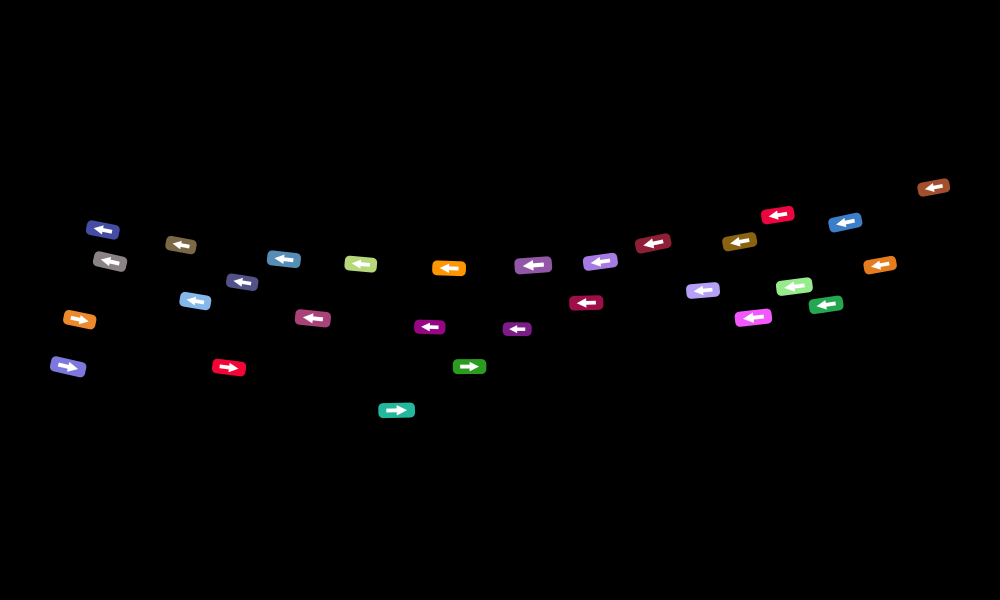

In [115]:
render(scene)

In [ ]:
# point of information: used to read trajdata information from text file
# uses Base.read overload defined in Records.jl/src/listrecords.jl
traj_ngsim = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_i101_trajectories-0750am-0805am.txt", "r");